<a href="https://colab.research.google.com/github/NaziaHasanDana/DeepLearning/blob/main/ResNet_HeatMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

# Path to your zip file
zip_path = '/content/covid-19_healthy.zip'

# Directory where you want to extract the files
extract_dir = '/content/covid-19_healthy'

# Create the target directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to: {extract_dir}")


Dataset extracted to: /content/covid-19_healthy


In [ ]:
# List the files in the extracted directory
!ls /content/covid-19_healthy


covid-19  healthy  pneumonia


In [ ]:
from PIL import Image
import os

# Path to the extracted dataset
data_dir = '/content/covid-19_healthy'

# Loop through each subdirectory and access images
for category in os.listdir(data_dir):  # e.g., 'pneumonia', 'healthy', etc.
    category_path = os.path.join(data_dir, category)

    # Ensure it's a directory
    if os.path.isdir(category_path):
        # List all files in the category folder
        image_files = os.listdir(category_path)

        # Check if there are images in the folder
        if len(image_files) > 0:
            # Load and display the first image in this category
            img_path = os.path.join(category_path, image_files[0])
            img = Image.open(img_path)
            img.show()
            print(f"Displaying an image from category: {category}")
            break  # Exit after displaying one image


Displaying an image from category: healthy


In [ ]:
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)

    if os.path.isdir(category_path):
        # Display the first image from each category
        image_files = os.listdir(category_path)
        if len(image_files) > 0:
            img_path = os.path.join(category_path, image_files[0])
            img = Image.open(img_path)
            img.show()
            print(f"Displaying an image from category: {category}")


Displaying an image from category: healthy
Displaying an image from category: pneumonia
Displaying an image from category: covid-19


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Path to the unzipped dataset in Google Colab
dataset_path = "/content/covid-19_healthy"

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Traverse the dataset directory
for label in os.listdir(dataset_path):
    label_folder = os.path.join(dataset_path, label)
    if os.path.isdir(label_folder):  # Ensure it's a directory
        for img_file in os.listdir(label_folder):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Only process image files
                image_paths.append(os.path.join(label_folder, img_file))
                labels.append(label)

# Create a DataFrame
data_df = pd.DataFrame({
    'image_paths': image_paths,
    'labels': labels
})

# Confirm the structure of the DataFrame
print("DataFrame Head:")
print(data_df.head())
print("\nDataFrame Info:")
print(data_df.info())

# Split the data into training (80%), validation (10%), and test sets (10%)
strat = data_df['labels']
train_df, temp_df = train_test_split(data_df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

# Further split temp_df equally for validation and test sets (each 10%)
strat_temp = temp_df['labels']
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat_temp)

# Print the sizes of each split
print(f"Training Set: {len(train_df)} samples")
print(f"Validation Set: {len(valid_df)} samples")
print(f"Test Set: {len(test_df)} samples")

# Create image data generators for the training, validation, and test datasets
train_augmentor = ImageDataGenerator(horizontal_flip=True, rescale=1.0 / 255)
test_augmentor = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_augmentor.flow_from_dataframe(
    train_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

valid_gen = test_augmentor.flow_from_dataframe(
    valid_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

test_gen = test_augmentor.flow_from_dataframe(
    test_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=16
)

# Set the batch size, image size, and number of classes
batch_size = 16
img_height, img_width = 224, 224
num_classes = len(train_gen.class_indices)

# Create ResNet101 model with pre-trained weights
resnet = ResNet101(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

# Add new fully connected layers
x = resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=resnet.input, outputs=predictions)

# Freeze pre-trained layers
for layer in resnet.layers:
    layer.trainable = False

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_gen,
    epochs=30,
    callbacks=[early_stop],
    validation_data=valid_gen,
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


DataFrame Head:
                                         image_paths   labels
0  /content/covid-19_healthy/healthy/7c5add91-0e3...  healthy
1  /content/covid-19_healthy/healthy/7fe666e4-825...  healthy
2  /content/covid-19_healthy/healthy/9124decc-be2...  healthy
3  /content/covid-19_healthy/healthy/2ab70125-b74...  healthy
4  /content/covid-19_healthy/healthy/65902ad5-4a6...  healthy

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5887 entries, 0 to 5886
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_paths  5887 non-null   object
 1   labels       5887 non-null   object
dtypes: object(2)
memory usage: 92.1+ KB
None
Training Set: 4709 samples
Validation Set: 589 samples
Test Set: 589 samples
Found 4709 validated image filenames belonging to 3 classes.
Found 589 validated image filenames belonging to 3 classes.
Found 589 validated image filenames belonging to 3 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


295/295 ━━━━━━━━━━━━━━━━━━━━ 55s 136ms/step - accuracy: 0.5864 - loss: 1.0274 - val_accuracy: 0.6350 - val_loss: 1.1913
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.6415 - loss: 0.8196 - val_accuracy: 0.7148 - val_loss: 0.6473
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.6832 - loss: 0.7184 - val_accuracy: 0.7267 - val_loss: 0.6290
Epoch 4/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.7022 - loss: 0.6532 - val_accuracy: 0.6418 - val_loss: 0.9178
Epoch 5/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.6952 - loss: 0.7282 - val_accuracy: 0.6791 - val_loss: 0.6622
Epoch 6/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.7031 - loss: 0.6739 - val_accuracy: 0.7334 - val_loss: 0.6118
Epoch 7/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.7071 - loss: 0.6678 - val_accuracy: 0.7284 - val_loss: 0.5914
Epoch 8/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.7157 - loss: 0.6364 - val_accu

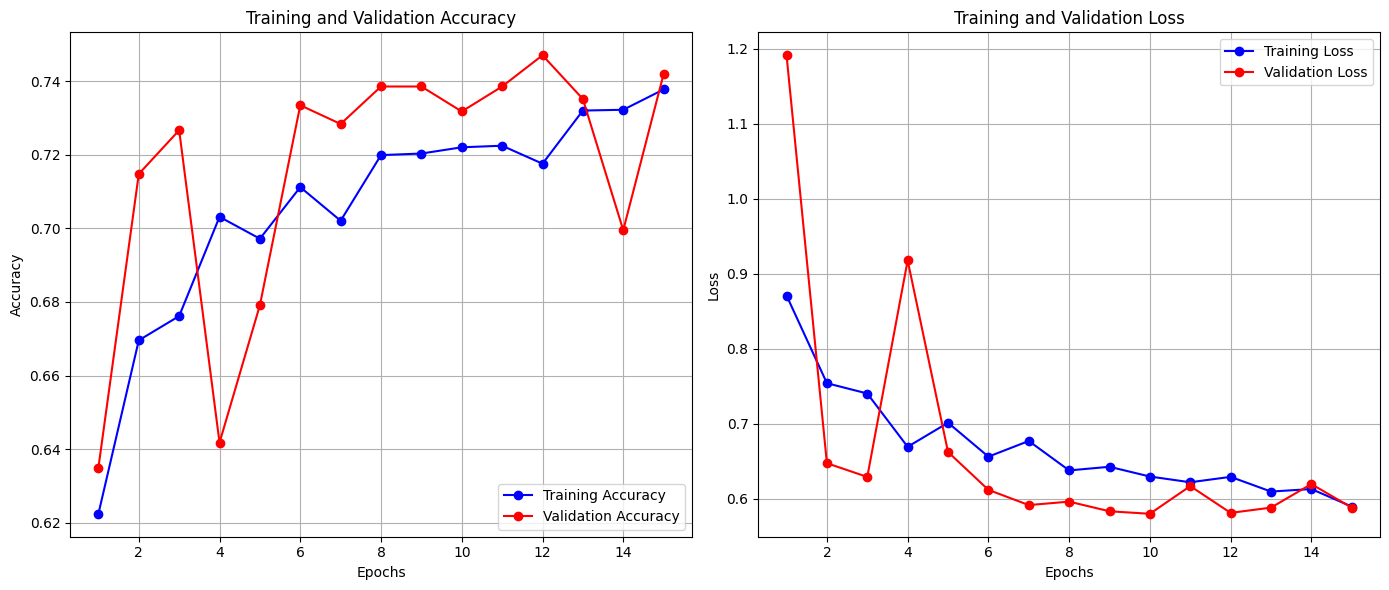

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation metrics from history
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Define epochs dynamically based on history length
epochs_range = range(1, len(acc) + 1)

# Set up the figure size and layout
plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'b-', label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'b-', label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
model.save('ResNet_Saved.h5')

In [ ]:
# Save the trained model to a file
model.save('ResNet101_Classification_Model.h5', save_format='h5')


In [ ]:
# Necessary imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import random
from PIL import Image

# Visualization imports
from IPython.display import Image as IPImage, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Check TensorFlow and Keras versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Functions for visualization or further operations can be added below


TensorFlow version: 2.17.1
Keras version: 3.5.0


In [ ]:
model.save('ResNet_Saved.keras')  # Saves in the new format


In [ ]:
from tensorflow import keras

# Set up the Xception model
model_builder = keras.applications.xception.Xception  # Pre-trained Xception model
img_size = (224, 224)  # Image size expected by Xception
preprocess_input = keras.applications.xception.preprocess_input  # Preprocessing for Xception
decode_predictions = keras.applications.xception.decode_predictions  # Decoding predictions

# Load the pre-trained Xception model without the top layer for transfer learning
base_model = model_builder(
    weights="imagenet",  # Use weights pre-trained on ImageNet
    include_top=False,   # Exclude the fully connected layers
    input_shape=img_size + (3,)  # Input shape for RGB images
)

# Add custom classification head
from tensorflow.keras import layers

# Freeze the base model
base_model.trainable = False

# Build the custom model
inputs = keras.Input(shape=img_size + (3,))
x = preprocess_input(inputs)  # Preprocess input for Xception
x = base_model(x, training=False)  # Pass through the pre-trained model
x = layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = layers.Dropout(0.2)(x)  # Add a dropout layer for regularization
outputs = layers.Dense(3, activation="softmax")(x)  # Final classification layer (3 classes in this example)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def get_img_array(img_path, size):
    """
    Converts an image file into a preprocessed Numpy array suitable for model input.

    Parameters:
    - img_path (str): Path to the image file.
    - size (tuple): Target size (height, width) for resizing the image.

    Returns:
    - array (np.ndarray): Preprocessed image array with shape (1, height, width, 3).
    """
    try:
        # Load the image as a PIL image and resize it
        img = keras.preprocessing.image.load_img(img_path, target_size=size)
        # Convert the image to a float32 Numpy array
        array = keras.preprocessing.image.img_to_array(img)
        # Expand dimensions to create a batch of size 1
        array = np.expand_dims(array, axis=0)
        # Normalize the image array (if required by the model, apply here)
        return array
    except Exception as e:
        raise ValueError(f"Error processing the image at {img_path}: {e}")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.

    Parameters:
    - img_array (np.ndarray): Preprocessed image array with shape (1, height, width, 3).
    - model (tf.keras.Model): Pre-trained model.
    - last_conv_layer_name (str): Name of the last convolutional layer in the model.
    - pred_index (int, optional): Class index for which the heatmap is calculated.
      If None, the top predicted class is used.

    Returns:
    - heatmap (np.ndarray): Grad-CAM heatmap with values normalized between 0 and 1.
    """
    try:
        # Define a model mapping inputs to the last convolutional layer and predictions
        grad_model = tf.keras.models.Model(
            [model.inputs],
            [model.get_layer(last_conv_layer_name).output, model.output]
        )

        # Compute the gradient of the target class with respect to the feature map
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # Compute gradients of the target class with respect to the feature map
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # Pool the gradients across the spatial dimensions
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Scale the feature map by the importance of each channel
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # Normalize the heatmap to [0, 1]
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    except Exception as e:
        raise ValueError(f"Error generating Grad-CAM heatmap: {e}")


In [ ]:
import numpy as np
from tensorflow import keras
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path=None, alpha=0.4):
    """
    Generates and optionally saves a Grad-CAM overlay on the original image.

    Parameters:
    - img_path (str): Path to the original image file.
    - heatmap (np.ndarray): Grad-CAM heatmap array normalized between 0 and 1.
    - cam_path (str, optional): Path to save the superimposed Grad-CAM image.
                                If None, the image is not saved.
    - alpha (float): Transparency factor for the heatmap overlay. Default is 0.4.

    Returns:
    - superimposed_img (PIL.Image.Image): Superimposed image with Grad-CAM overlay.
    - jet_heatmap (PIL.Image.Image): RGB heatmap image.
    """
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale the heatmap to the range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Apply the jet colormap to the heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # Extract RGB values
    jet_heatmap = jet_colors[heatmap]        # Map heatmap values to RGB

    # Convert the heatmap to an image
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))  # Resize to match original image
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed Grad-CAM image if a path is provided
    if cam_path:
        superimposed_img.save(cam_path)

    return superimposed_img, jet_heatmap


In [ ]:
# Load the saved model
model = keras.models.load_model(
    filepath='ResNet_Saved.keras',
    custom_objects=None,  # Add any custom layers or loss functions here, if needed
    compile=True          # Ensure the model is compiled upon loading
)

# Display model summary to confirm successful loading
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 94,040,456 (358.74 MB)

 Trainable params: 25,691,139 (98.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

 Optimizer params: 25,691,141 (98.00 MB)

In [ ]:
# Inspect the model architecture to find the correct layer name
model.summary()

# Specify the last convolutional layer name for Grad-CAM
# Confirm this layer exists in your model
last_conv_layer_name = "conv5_block3_out"

# Validate if the layer exists in the model
if last_conv_layer_name not in [layer.name for layer in model.layers]:
    raise ValueError(f"Layer '{last_conv_layer_name}' not found in the model.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 94,040,456 (358.74 MB)

 Trainable params: 25,691,139 (98.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

 Optimizer params: 25,691,141 (98.00 MB)

In [ ]:
# Remove the last layer's softmax activation by creating a new model
model_new = keras.models.Model(inputs=model.inputs, outputs=model.layers[-2].output)

# This will give you a model without the last softmax layer
#model_new.summary()  # Verify the new model architecture


In [ ]:
import os
import random

# Directory path
directory = '/content/covid-19_healthy'  # replace with the path to your directory
num_files_to_choose = 3  # number of files to select

# Check if the directory exists and is not empty
if os.path.exists(directory) and os.listdir(directory):
    # Get a list of all files in the directory
    all_files = os.listdir(directory)

    # Ensure there are enough files in the directory to choose from
    if len(all_files) >= num_files_to_choose:
        # Randomly choose the specified number of files
        chosen_files = random.sample(all_files, num_files_to_choose)

        # Create a list of the paths to the chosen files
        file_paths = [os.path.join(directory, file) for file in chosen_files]
        print("Chosen file paths:", file_paths)
    else:
        print(f"Not enough files in the directory. Found {len(all_files)} files, but {num_files_to_choose} were requested.")
else:
    print("Directory does not exist or is empty.")


Chosen file paths: ['/content/covid-19_healthy/pneumonia', '/content/covid-19_healthy/covid-19', '/content/covid-19_healthy/healthy']


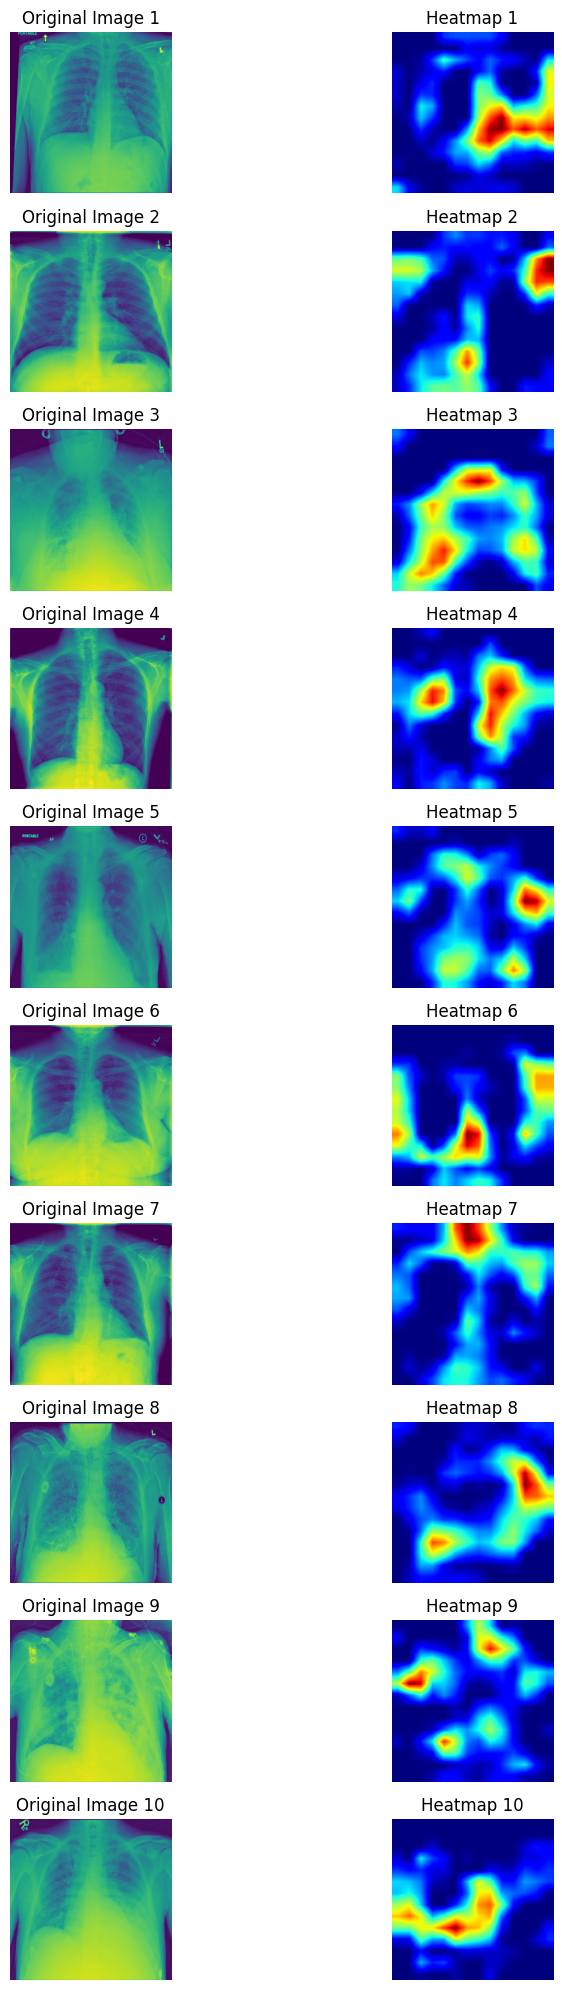

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import backend as K
import cv2

# Parameters
directory = '/content/covid-19_healthy'  # Path to the image directory in Google Colab
num_files_to_choose = 10  # Choose 10 images
last_conv_layer_name = "block5_conv3"  # For VGG16

# Load pre-trained model (VGG16)
model = VGG16(weights='imagenet')

# Helper functions
def get_img_array(img_path, size=(224, 224)):
    """Load an image file and return the corresponding image array"""
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """Generate Grad-CAM heatmap for the input image"""

    # Get the last convolutional layer's output
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Create a model that maps the input image to the activations of the last conv layer and the model's predictions
    grad_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        # Watch the input image tensor
        last_conv_layer_output, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])  # Get the class index with highest probability
        class_output = preds[:, class_idx]  # Get the model's output for the predicted class

    # Get the gradient of the class output w.r.t the output feature map of the last conv layer
    grads = tape.gradient(class_output, last_conv_layer_output)

    # Pool the gradients across all the axes to get the mean intensity of the gradients
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Remove the batch dimension from last_conv_layer_output
    last_conv_layer_output = last_conv_layer_output[0]  # Shape: (14, 14, 512)

    # Expand the dimensions of pooled_grads to match last_conv_layer_output's shape (14, 14, 512)
    pooled_grads = K.reshape(pooled_grads, (1, 1, 512))  # Reshape to (1, 1, 512)
    pooled_grads = K.tile(pooled_grads, (14, 14, 1))  # Tile to match (14, 14, 512)

    # Multiply each channel of the feature map by "how important" that channel is
    heatmap = last_conv_layer_output * pooled_grads.numpy()

    # Sum over all the channels to get the final heatmap
    heatmap = np.mean(heatmap, axis=-1)  # Sum across channels

    # Normalize the heatmap to a range of 0 to 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Recursively search for image files in subdirectories
image_files = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, file))

# Check if there are enough image files to choose from
if len(image_files) < num_files_to_choose:
    print(f"Warning: Only {len(image_files)} image files available, but trying to select {num_files_to_choose}.")
    num_files_to_choose = len(image_files)  # Adjust num_files_to_choose to available files

# Randomly choose 'num_files_to_choose' files
chosen_files = random.sample(image_files, num_files_to_choose)

# Create a figure for displaying the images
fig, ax = plt.subplots(nrows=num_files_to_choose, ncols=2, figsize=(10, 2 * num_files_to_choose))

# Loop through the chosen files
for i, file_path in enumerate(chosen_files):
    # Read image from file
    img = mpimg.imread(file_path)

    # Preprocess image for model input
    img_array = preprocess_input(get_img_array(file_path, size=(224, 224)))

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Resize heatmap to match the original image dimensions
    heatmap_resized = np.uint8(255 * heatmap)  # Convert heatmap to 255 scale
    heatmap_resized = cv2.resize(heatmap_resized, (img.shape[1], img.shape[0]))  # Resize to match image shape

    # Plot original image and heatmap
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(f"Original Image {i+1}")
    ax[i, 0].axis('off')

    ax[i, 1].imshow(heatmap_resized, cmap="jet")
    ax[i, 1].set_title(f"Heatmap {i+1}")
    ax[i, 1].axis('off')

# Adjust spacing between subplots
fig.tight_layout()
plt.show()


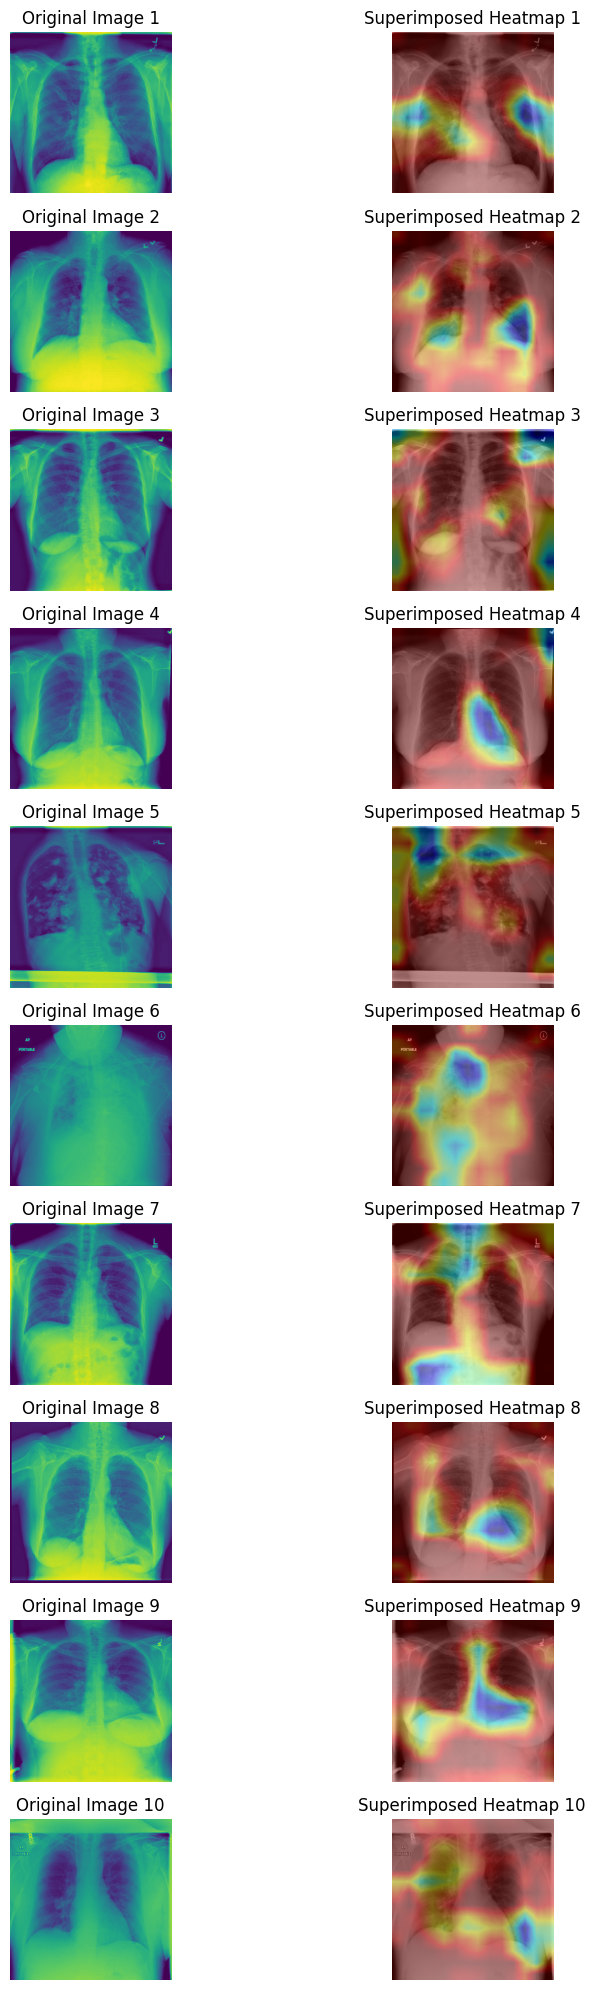

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import backend as K
import cv2

# Parameters
directory = '/content/covid-19_healthy'  # Path to the image directory
num_files_to_choose = 10  # Choose 10 images
last_conv_layer_name = "block5_conv3"  # For VGG16

# Load pre-trained model (VGG16)
model = VGG16(weights='imagenet')

# Helper functions
def get_img_array(img_path, size=(224, 224)):
    """Load an image file and return the corresponding image array"""
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """Generate Grad-CAM heatmap for the input image"""

    # Get the last convolutional layer's output
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Create a model that maps the input image to the activations of the last conv layer and the model's predictions
    grad_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        # Watch the input image tensor
        last_conv_layer_output, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])  # Get the class index with highest probability
        class_output = preds[:, class_idx]  # Get the model's output for the predicted class

    # Get the gradient of the class output w.r.t the output feature map of the last conv layer
    grads = tape.gradient(class_output, last_conv_layer_output)

    # Pool the gradients across all the axes to get the mean intensity of the gradients
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Remove the batch dimension from last_conv_layer_output
    last_conv_layer_output = last_conv_layer_output[0]  # Shape: (14, 14, 512)

    # Expand the dimensions of pooled_grads to match last_conv_layer_output's shape (14, 14, 512)
    pooled_grads = K.reshape(pooled_grads, (1, 1, 512))  # Reshape to (1, 1, 512)
    pooled_grads = K.tile(pooled_grads, (14, 14, 1))  # Tile to match (14, 14, 512)

    # Multiply each channel of the feature map by "how important" that channel is
    heatmap = last_conv_layer_output * pooled_grads.numpy()

    # Sum over all the channels to get the final heatmap
    heatmap = np.mean(heatmap, axis=-1)  # Sum across channels

    # Normalize the heatmap to a range of 0 to 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def superimpose_heatmap_on_image(img, heatmap, alpha=0.4):
    """Superimpose the heatmap on the original image"""
    # Ensure the image has 3 channels (RGB)
    if len(img.shape) == 2:  # If the image is grayscale, convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Resize heatmap to match the original image dimensions
    heatmap_resized = np.uint8(255 * heatmap)  # Convert heatmap to 255 scale
    heatmap_resized = cv2.resize(heatmap_resized, (img.shape[1], img.shape[0]))  # Resize to match image shape

    # Apply a colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)

    return superimposed_img

# Recursively search for image files in subdirectories
image_files = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, file))

# Check if there are enough image files to choose from
if len(image_files) < num_files_to_choose:
    print(f"Warning: Only {len(image_files)} image files available, but trying to select {num_files_to_choose}.")
    num_files_to_choose = len(image_files)  # Adjust num_files_to_choose to available files

# Randomly choose 'num_files_to_choose' files
chosen_files = random.sample(image_files, num_files_to_choose)

# Create a figure for displaying the images
fig, ax = plt.subplots(nrows=num_files_to_choose, ncols=2, figsize=(10, 2 * num_files_to_choose))

# Loop through the chosen files
for i, file_path in enumerate(chosen_files):
    # Read image from file
    img = mpimg.imread(file_path)

    # Preprocess image for model input
    img_array = preprocess_input(get_img_array(file_path, size=(224, 224)))

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Superimpose the heatmap on the original image
    superimposed_img = superimpose_heatmap_on_image(img, heatmap)

    # Plot original image and superimposed image
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(f"Original Image {i+1}")
    ax[i, 0].axis('off')

    ax[i, 1].imshow(superimposed_img)
    ax[i, 1].set_title(f"Superimposed Heatmap {i+1}")
    ax[i, 1].axis('off')

# Adjust spacing between subplots
fig.tight_layout()
plt.show()
